In [3]:
import sys
import os
import pandas as pd

import numpy as np
import seaborn as sns
from scipy import stats
import scipy

%pylab inline
import pylab as pl
pl.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [4]:
workfolder = os.getenv('Projects') + '/Uber_market'
os.chdir(workfolder)

# Import Trip Data

In [5]:
#Import Uber data
uber_aggr = {}
for year in ['2014', '2015']:
    uber_aggr[year] = pd.read_csv('Data/uber_aggr_{}.csv'.format(year))
    uber_aggr[year]['share'] = uber_aggr[year].tripcount.astype(float)/uber_aggr[year].month_count

In [6]:
#Import TLC data
tlc_aggr = {}
for year in ['2013','2014', '2015']:
    tlc_aggr[year] = pd.read_csv('Data/tlc-trip-data/tlc_{}_trips.csv'.format(year))
    tlc_aggr[year] = tlc_aggr[year].rename(columns={'share_month': 'share'})

# I - Education densities
## 1. Uber

In [9]:
#Import education data
acs_educ = {} 
acs_educ['GEOID'] = pd.read_csv('Data/Output/acs_educ.csv').drop('Unnamed: 0',1)

#Aggregate by NTA
acs_educ['NTACode'] = acs_educ['GEOID'].groupby('NTACode').sum().reset_index()

#Share by NTA Code
for var in [c for c in acs_educ['NTACode'].columns if c[:3] == 'edu']:
    acs_educ['NTACode']['r{}'.format(var)] = acs_educ['NTACode'][var]/acs_educ['NTACode'].tot_educ

In [10]:
#Merge dataframes
uber_educ = {}
for year, geo in [('2014', 'GEOID'), ('2015', 'NTACode')]:
    uber_educ[year] = uber_aggr[year].drop('Unnamed: 0',1).merge(acs_educ[geo], on=geo, how='left')
    #uber_educ[year] = uber_educ[year].loc[uber_educ[year].tot_educ.isnull() == False]

=> Investigate which uber_educ census tracts have no educ value (most of them in NJ), but not only

In [11]:
print ("Share of null values for education: {0:.2f}%"
       .format(uber_educ['2014'][uber_educ['2014'].tot_educ.isnull() == True].tripcount.sum()*100./
               uber_educ['2014'].tripcount.sum()))

#Count of trips by census tracts
uber_educ['2014'][uber_educ['2014'].tot_educ.isnull() == True].GEOID.astype(str).str[:2].value_counts()

Share of null values for education: 1.77


34    1386
36    1007
Name: GEOID, dtype: int64

In [12]:
ub_educ_dens = pd.DataFrame()

#Split month data
for year, df in uber_educ.items():
    for mth in uber_educ[year].month.unique():
        a = df.loc[df.month == mth, 'share']
        b = df.loc[df.month == mth, [c for c in df.columns if c[:5] == 'reduc']]
        
        #Infer uber passengers distribution in terms of education
        ub_educ_dens['{}'.format(year[2:] + '_0' + str(mth))] = b.multiply(a, axis="index").sum()

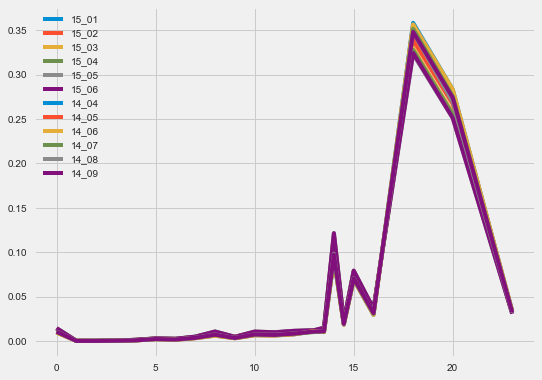

In [13]:
educ_bins = [float(i[6:]) for i in ub_educ_dens.index]

#Plot the density 
pl.figure(figsize=(8,6))
for month in ub_educ_dens.columns:
    pl.plot(educ_bins,ub_educ_dens[month], label=month)
    pl.legend()

## 2. Taxis

In [14]:
#Merge TLC and education data
tlc_educ = {}
for year, df in tlc_aggr.items():
    tlc_educ[year] = tlc_aggr[year].drop('Unnamed: 0',1).merge(acs_educ['GEOID'], on='GEOID', how='left')

=> Investigate which tlc_educ census tracts have no educ value (most of them in NJ), but not only

In [15]:
print ("Share of TLC trips in census tracts with no education value: {0:.2f}%"
       .format(tlc_educ['2014'][tlc_educ['2014'].tot_educ.isnull() == True].passenger_count.sum()*100./
               tlc_educ['2014'].passenger_count.sum()))

#Count by census tract
tlc_educ['2014'][tlc_educ['2014'].tot_educ.isnull() == True].GEOID.astype(str).str[:2].value_counts()

Share of TLC trips in census tracts with no education value 0.05%


36    663
34    267
Name: GEOID, dtype: int64

In [17]:
tlc_educ_dens = pd.DataFrame()

#Split by month
for year, df in tlc_educ.items():
    for mth in tlc_educ[year].month.unique():
        a = df.loc[df.month == mth, 'share']
        b = df.loc[df.month == mth, [c for c in df.columns if c[:5] == 'reduc']]
        
        #Infer distribution of TLC passengers in terms of education 
        tlc_educ_dens['{}'.format(year[2:] + '_0' + str(mth))] = b.multiply(a, axis="index").sum()

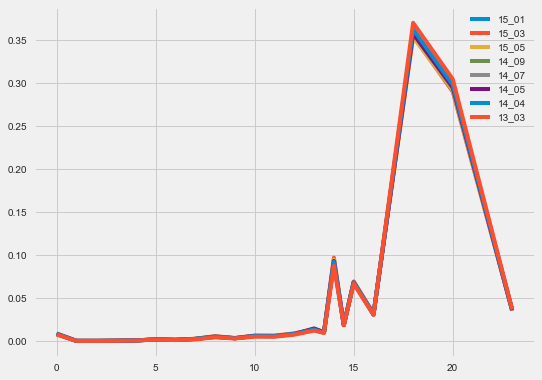

In [18]:
pl.figure(figsize=(8,6))
for month in tlc_educ_dens.columns:
    pl.plot(educ_bins,tlc_educ_dens[month], label=month)
    pl.legend()

# II - Income Densities
## 1. Uber

In [20]:
#Census data
acs_inc = {} 
acs_inc['GEOID'] = pd.read_csv(os.getenv('CUSP') + '/Data/Census/acs_inc.csv').drop('Unnamed: 0',1)

#Share by NTA area
acs_inc['NTACode'] = acs_inc['GEOID'].groupby('NTACode').sum().reset_index()
for var in [c for c in acs_inc['NTACode'].columns if c[:3] == 'inc']:
    acs_inc['NTACode']['r{}'.format(var)] = acs_inc['NTACode'][var]/acs_inc['NTACode'].hh_tot

In [21]:
uber_inc = {}

#Merge dataframes
for year, geo in [('2014', 'GEOID'), ('2015', 'NTACode')]:
    uber_inc[year] = uber_aggr[year].drop('Unnamed: 0',1).merge(acs_inc[geo], on=geo, how='left')

In [23]:
print ("Share of Uber trips in census tracts with no income value: {0:.2f}%"
       .format(uber_inc['2014'][uber_inc['2014'].hh_tot.isnull() == True].tripcount.sum()*100./
               uber_inc['2014'].tripcount.sum()))

#Tracts with no income value
uber_inc['2014'][uber_inc['2014'].hh_tot.isnull() == True].GEOID.astype(str).str[:2].value_counts()

Share of Uber trips in census tracts with no income value: 5.81%


34    1386
36    1133
Name: GEOID, dtype: int64

In [24]:
ub_inc_dens = pd.DataFrame()

#Split by month
for year, df in uber_inc.items():
    for mth in uber_inc[year].month.unique():
        a = df.loc[df.month == mth, 'share']
        b = df.loc[df.month == mth, [c for c in df.columns if c[:4] == 'rinc']]
        
        #Infer distribution of uber passengers in terms of income
        ub_inc_dens['{}'.format(year[2:] + '_0' + str(mth))] = b.multiply(a, axis="index").sum()

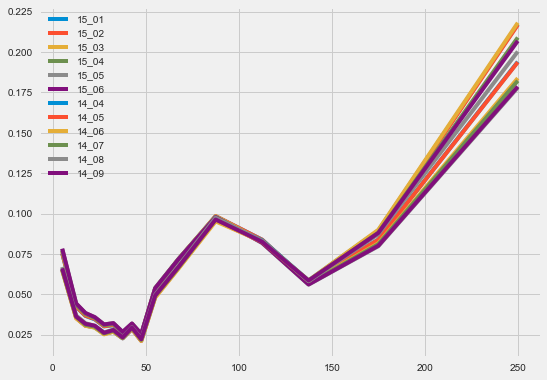

In [25]:
inc_bins = [5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 
     47.5, 55, 67.5, 87.5, 112.5, 137.5, 175, 250]

#Plot
pl.figure(figsize=(8,6))
for month in ub_inc_dens.columns:
    pl.plot(inc_bins,ub_inc_dens[month], label=month)
    pl.legend()

## 2. Taxis

In [28]:
#Merge dataframes
tlc_inc = {}
for year, df in tlc_aggr.items():
    tlc_inc[year] = tlc_aggr[year].drop('Unnamed: 0',1).merge(acs_inc['GEOID'], on='GEOID', how='left')

In [29]:
print ("Share of TLC trips in census tracts with no income value: {0:.2f}%"
       .format(tlc_inc['2014'][tlc_inc['2014'].hh_tot.isnull() == True].passenger_count.sum()*100./
               tlc_inc['2014'].passenger_count.sum()))

#Census tracts with no income value for TLC
tlc_inc['2014'][tlc_inc['2014'].hh_tot.isnull() == True].GEOID.astype(str).str[:2].value_counts()

Share of TLC trips in census tracts with no income value: 4.77%


36    819
34    267
Name: GEOID, dtype: int64

In [31]:
tlc_inc_dens = pd.DataFrame()

#Split by month
for year, df in tlc_inc.items():
    for mth in tlc_inc[year].month.unique():
        a = df.loc[df.month == mth, 'share']
        b = df.loc[df.month == mth, [c for c in df.columns if c[:4] == 'rinc']]
        
        #Infer the distribution of income for TLC passengers
        tlc_inc_dens['{}'.format(year[2:] + '_0' + str(mth))] = b.multiply(a, axis="index").sum()

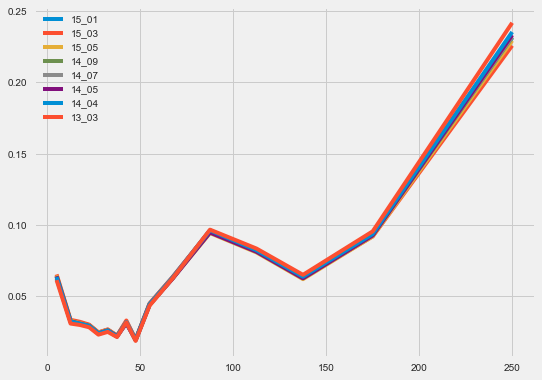

In [32]:
#Plot
pl.figure(figsize=(8,6))
for month in tlc_inc_dens.columns:
    pl.plot(inc_bins,tlc_inc_dens[month], label=month)
    pl.legend()

# III - Age densities
## 1. Uber

In [33]:
#Import Census Age data
acs_age = {} 
acs_age['GEOID'] = pd.read_csv('Data/Output/acs_age.csv').drop('Unnamed: 0',1)

acs_age['NTACode'] = acs_age['GEOID'].groupby('NTACode').sum().reset_index()

#Share by NTA area
for var in [c for c in acs_age['NTACode'].columns if (c[:3] == 'age')] + ['male', 'female']:
    acs_age['NTACode']['r{}'.format(var)] = acs_age['NTACode'][var]/acs_age['NTACode'].tot_pop

In [35]:
uber_age = {}

#Merge dataframes
for year, geo in [('2014', 'GEOID'), ('2015', 'NTACode')]:
    uber_age[year] = uber_aggr[year].drop('Unnamed: 0',1).merge(acs_age[geo], on=geo, how='left')

In [36]:
print ("Share of Uber trips in census tracts with no age value: {0:.2f}%"
       .format(uber_age['2014'][uber_age['2014'].tot_pop.isnull() == True].tripcount.sum()*100./
               uber_age['2014'].tripcount.sum()))

#Census tracts with no age value for TLC
uber_age['2014'][uber_age['2014'].tot_pop.isnull() == True].GEOID.astype(str).str[:2].value_counts()

Share of Uber trips in census tracts with no age value: 5.21%


34    1386
36    1101
Name: GEOID, dtype: int64

In [37]:
ub_age_dens = pd.DataFrame()

#Split by month
for year, df in uber_age.items():
    for mth in uber_age[year].month.unique():
        a = df.loc[df.month == mth, 'share']
        b = df.loc[df.month == mth, [c for c in df.columns if c[:4] == 'rage']]
        
        #Infer the distribution of uber passengers in terms of age
        ub_age_dens['{}'.format(year[2:] + '_0' + str(mth))] = b.multiply(a, axis="index").sum()

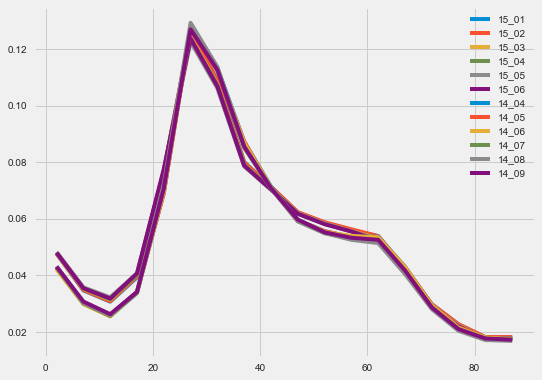

In [39]:
age_bins = [2 + 5*i for i in range(0,18)]

#Plot
pl.figure(figsize=(8,6))
for month in ub_age_dens.columns:
    pl.plot(age_bins,ub_age_dens[month], label=month)
    pl.legend()

In [40]:
ub_gder = pd.DataFrame()

for year, df in uber_age.items():
    for mth in uber_age[year].month.unique():
        a = df.loc[df.month == mth, 'share']
        b = df.loc[df.month == mth, ['rmale', 'rfemale']]
        
        #Infer the distribution of uber passengers by gender
        ub_gder['{}'.format(year[2:] + '_0' + str(mth))] = b.multiply(a, axis="index").sum()

## 2. Taxis

In [44]:
tlc_age = {}

#Merge dataframes
for year, df in tlc_aggr.items():
    tlc_age[year] = tlc_aggr[year].drop('Unnamed: 0',1).merge(acs_age['GEOID'], on='GEOID', how='left')

In [46]:
print ("Share of TLC trips in census tracts with no age value: {0:.2f}%"
       .format(tlc_age['2014'][tlc_age['2014'].tot_pop.isnull() == True].passenger_count.sum()*100./
               tlc_age['2014'].passenger_count.sum()))
       
#Census tracts with no age data for TLC
tlc_age['2014'][tlc_age['2014'].tot_pop.isnull() == True].GEOID.astype(str).str[:2].value_counts()

Share of TLC trips in census tracts with no age value: 3.46%


36    780
34    267
Name: GEOID, dtype: int64

In [48]:
tlc_age_dens = pd.DataFrame()

#Split by month
for year, df in tlc_age.items():
    for mth in tlc_age[year].month.unique():
        a = df.loc[df.month == mth, 'share']
        b = df.loc[df.month == mth, [c for c in df.columns if c[:4] == 'rage']]
        
        #Infer the distribution of TLC passengers by age
        tlc_age_dens['{}'.format(year[2:] + '_0' + str(mth))] = b.multiply(a, axis="index").sum()

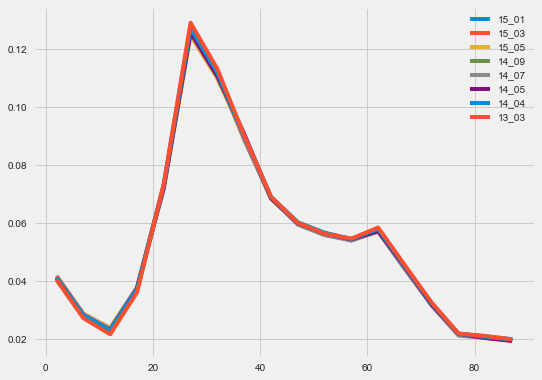

In [49]:
pl.figure(figsize=(8,6))

#Plot
for month in tlc_age_dens.columns:
    pl.plot(age_bins,tlc_age_dens[month], label=month)
    pl.legend()

In [50]:
tlc_gder = pd.DataFrame()

#Split by month
for year, df in tlc_age.items():
    for mth in tlc_age[year].month.unique():
        a = df.loc[df.month == mth, 'share']
        b = df.loc[df.month == mth, ['rmale', 'rfemale']]
        
        #Infer the distribution of TLC passengers in terms of Gender
        tlc_gder['{}'.format(year[2:] + '_0' + str(mth))] = b.multiply(a, axis="index").sum()

# IV - Differences
## 1. Education

In [51]:
#Difference between Uber and TLC education by education
diff_educ = pd.DataFrame()

for month in ['14_04', '14_05', '14_07', '14_09', '15_01', '15_03', '15_05']:
    diff_educ[month] = ub_educ_dens[month] - tlc_educ_dens[month]

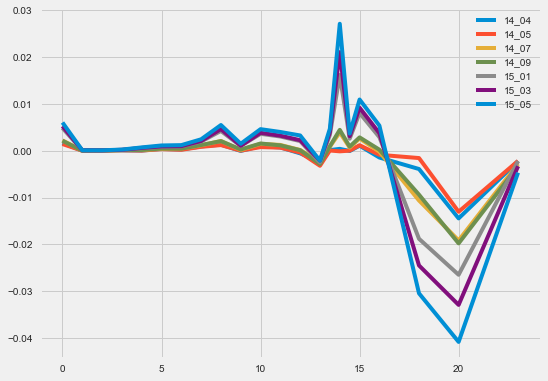

In [53]:
pl.figure(figsize=(8,6))

#Plot
for month in diff_educ.columns:
    pl.plot(educ_bins,diff_educ[month], label=month)
    pl.legend()

## 2. Income

In [54]:
#Difference between Uber and TLC income by education
diff_inc = pd.DataFrame()

for month in ['14_04', '14_05', '14_07', '14_09', '15_01', '15_03', '15_05']:
    diff_inc[month] = ub_inc_dens[month] - tlc_inc_dens[month]

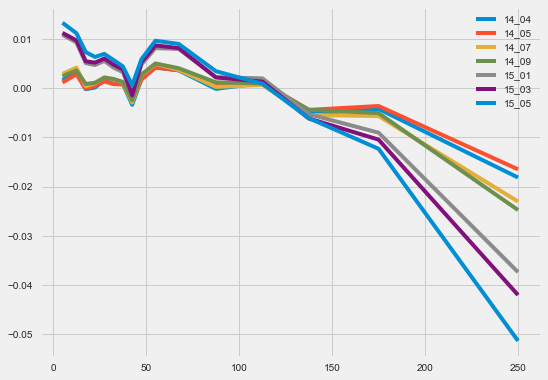

In [55]:
pl.figure(figsize=(8,6))

#Plot
for month in diff_inc.columns:
    pl.plot(inc_bins,diff_inc[month], label=month)
    pl.legend()

## 3. Age

In [56]:
diff_age = pd.DataFrame()

#Difference in Uber and TLC passengers in terms of Age
for month in ['14_04', '14_05', '14_07', '14_09', '15_01', '15_03', '15_05']:
    diff_age[month] = ub_age_dens[month] - tlc_age_dens[month]

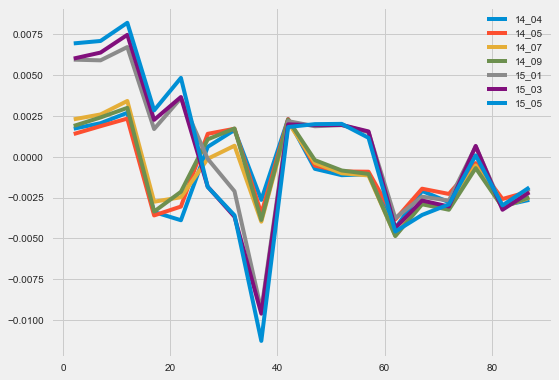

In [57]:
pl.figure(figsize=(8,6))

#Plot
for month in diff_age.columns:
    pl.plot(age_bins,diff_age[month], label=month)
    pl.legend()

# V - Kernel data
## 1. TLC

In [58]:
tlc_ker_age = {}
list_ = []

for mth in tlc_age_dens.columns:
    for i, pc in enumerate(tlc_age_dens[mth]):
        list_ += [age_bins[i]]*(tlc_age_dens[mth][i]*10000)
    tlc_ker_age[mth] = pd.DataFrame(list_, columns=['vals'])
    
tlc_ker_educ = {}
list_ = []
for mth in tlc_educ_dens.columns:
    for i, pc in enumerate(tlc_educ_dens[mth]):
        list_ += [educ_bins[i]]*(tlc_educ_dens[mth][i]*10000)
    tlc_ker_educ[mth] = pd.DataFrame(list_, columns=['vals'])
    
tlc_ker_inc = {}
list_ = []
for mth in tlc_inc_dens.columns:
    for i, pc in enumerate(tlc_inc_dens[mth]):
        list_ += [inc_bins[i]]*(tlc_inc_dens[mth][i]*10000)
    tlc_ker_inc[mth] = pd.DataFrame(list_, columns=['vals'])

/Users/arnoamabile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arnoamabile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arnoamabile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## 2. Uber

In [59]:
ub_ker_age = {}
list_ = []
for mth in ub_age_dens.columns:
    for i, pc in enumerate(ub_age_dens[mth]):
        list_ += [age_bins[i]]*(ub_age_dens[mth][i]*10000)
    ub_ker_age[mth] = pd.DataFrame(list_, columns=['vals'])
    
ub_ker_educ = {}
list_ = []
for mth in ub_educ_dens.columns:
    for i, pc in enumerate(ub_educ_dens[mth]):
        list_ += [educ_bins[i]]*(ub_educ_dens[mth][i]*10000)
    ub_ker_educ[mth] = pd.DataFrame(list_, columns=['vals'])
    
ub_ker_inc = {}
list_ = []
for mth in ub_inc_dens.columns:
    for i, pc in enumerate(ub_inc_dens[mth]):
        list_ += [inc_bins[i]]*(ub_inc_dens[mth][i]*10000)
    ub_ker_inc[mth] = pd.DataFrame(list_, columns=['vals'])

/Users/arnoamabile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arnoamabile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arnoamabile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## 3. Descriptive statistics for TLC passengers

In [88]:
print "AGE BRACKETS"
print "Inf 20: {0:.2f}%".format((tlc_ker_age['13_03'][tlc_ker_age['13_03'].vals <= 20]
                                .count()*100./tlc_ker_age['13_03'].count())[0])

print "21-35: {0:.2f}%".format((tlc_ker_age['13_03'][(tlc_ker_age['13_03'].vals > 20) & 
                                                   (tlc_ker_age['13_03'].vals <= 35)]
                              .count()*100./tlc_ker_age['13_03'].count())[0])

print "36-50: {0:.2f}%".format((tlc_ker_age['13_03'][(tlc_ker_age['13_03'].vals > 35) & 
                                                    (tlc_ker_age['13_03'].vals <= 50)]
                               .count()*100./tlc_ker_age['13_03'].count())[0])

print "51-70: {0:.2f}%".format((tlc_ker_age['13_03'][(tlc_ker_age['13_03'].vals > 50) & 
                                                     (tlc_ker_age['13_03'].vals <= 70)]
                                .count()*100./tlc_ker_age['13_03'].count())[0])

print "71-: {0:.2f}%".format((tlc_ker_age['13_03'][(tlc_ker_age['13_03'].vals > 70)]
                             .count()*100./tlc_ker_age['13_03'].count())[0])

print "\nINCOME BRACKETS"
print "Inf 10: {0:.2f}%".format((tlc_ker_inc['13_03'][tlc_ker_inc['13_03'].vals <= 10]
                                .count()*100./tlc_ker_inc['13_03'].count())[0])

print "10-50: {0:.2f}%".format((tlc_ker_inc['13_03'][(tlc_ker_inc['13_03'].vals > 10) & 
                                                     (tlc_ker_inc['13_03'].vals <= 50)]
                                .count()*100./tlc_ker_inc['13_03'].count())[0])

print "50-100: {0:.2f}%".format((tlc_ker_inc['13_03'][(tlc_ker_inc['13_03'].vals > 50) & 
                                                      (tlc_ker_inc['13_03'].vals <= 100)]
                                 .count()/tlc_ker_inc['13_03'].count())[0])

print "100-: {0:.2f}%".format((tlc_ker_inc['13_03'][(tlc_ker_inc['13_03'].vals > 100)]
                               .count()*100./tlc_ker_inc['13_03'].count())[0])

print "\nMale: {0:.2f}%".format(tlc_gder['13_03'].rmale*100.)
print "Female: {0:.2f}%".format(tlc_gder['13_03'].rfemale*100.)

AGE BRACKETS
Inf 20: 13.43%
21-35: 32.17%
36-50: 22.61%
51-70: 22.03%
71-: 9.76%

INCOME BRACKETS
Inf 10: 6.68%
10-50: 22.63%
50-100: 0.21%
100-: 49.40%

Male: 45.88%
Female: 51.27%


## 4. Sample bias

In [95]:
#2013 Income data
inc13 = [0, tlc_ker_inc['13_03'][tlc_ker_inc['13_03'].vals <= 10].count()/tlc_ker_inc['13_03'].count(), 
         tlc_ker_inc['13_03'][(tlc_ker_inc['13_03'].vals > 10) & 
                              (tlc_ker_inc['13_03'].vals <= 50)].count()/tlc_ker_inc['13_03'].count(),
         tlc_ker_inc['13_03'][(tlc_ker_inc['13_03'].vals > 50) & 
                                     (tlc_ker_inc['13_03'].vals <= 100)].count()/tlc_ker_inc['13_03'].count(),
         tlc_ker_inc['13_03'][(tlc_ker_inc['13_03'].vals > 100)].count()/tlc_ker_inc['13_03'].count()]

inc_book = [0.17,0.11,0.12,0.18,0.42]

#Dataframe
test_inc = pd.DataFrame(data=[0]*5 + [1]*5).rename(columns={0:'book'})
test_inc['var'] = ['No answer','Less than $10k', '\$10k-\$50k', '\$50k-\$100k', 'More than $100k']*2
test_inc.loc[(test_inc.book == 0),'pc'] = inc13
test_inc.loc[(test_inc.book==1), 'pc'] = inc_book

In [96]:
#2013 Age data
age13 = [tlc_ker_age['13_03'][tlc_ker_age['13_03'].vals <= 20].count()/tlc_ker_age['13_03'].count(),
         tlc_ker_age['13_03'][(tlc_ker_age['13_03'].vals > 20) & 
                                     (tlc_ker_age['13_03'].vals <= 35)].count()/tlc_ker_age['13_03'].count(),
         tlc_ker_age['13_03'][(tlc_ker_age['13_03'].vals > 35) & 
                                     (tlc_ker_age['13_03'].vals <= 50)].count()/tlc_ker_age['13_03'].count(),
         tlc_ker_age['13_03'][(tlc_ker_age['13_03'].vals > 50) & 
                                     (tlc_ker_age['13_03'].vals <= 70)].count()/tlc_ker_age['13_03'].count(),
         tlc_ker_age['13_03'][(tlc_ker_age['13_03'].vals > 70)].count()/tlc_ker_age['13_03'].count()]

age_book = [0.35,0.35,0.13,0.05,0.12]

#Dataframe
test_age = pd.DataFrame(data=[0]*5 + [1]*5).rename(columns={0:'book'})
test_age['var'] = ['Less than 20 y/o', '21-35 y/o', '36-50 y/o', '51-70 y/o', 'More than 71 y/o']*2
test_age.loc[(test_age.book == 0),'pc'] = age13
test_age.loc[(test_age.book==1), 'pc'] = age_book

In [97]:
#Income
test_inc.loc[test_inc.book == 0, 'book'] = 'Estimate'
test_inc.loc[test_inc.book == 1, 'book'] = 'Factbook'
test_inc = test_inc.rename(columns={'book': 'Sample'})

#Age
test_age.loc[test_age.book == 0, 'book'] = 'Estimate'
test_age.loc[test_age.book == 1, 'book'] = 'Factbook'
test_age = test_age.rename(columns={'book': 'Sample'})

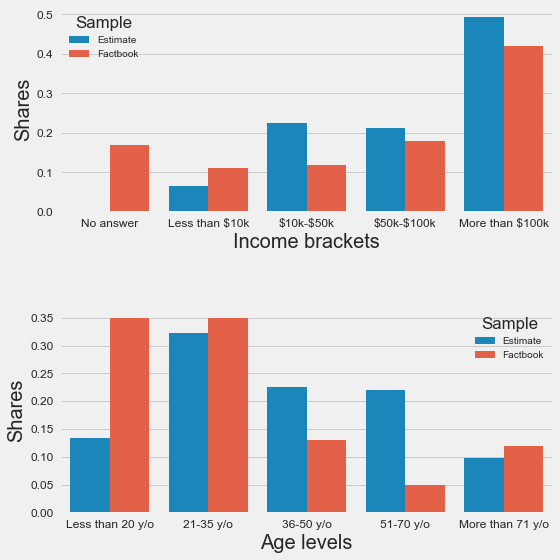

In [99]:
fig = pl.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
sns.barplot(x='var', y='pc', hue='Sample', data=test_inc, ax=ax1)
pl.xlabel('Income brackets', fontsize=20)
pl.ylabel('Shares', fontsize=20)
#pl.legend(fontsize=15)
pl.xticks(fontsize=12)
pl.yticks(fontsize=12)

ax2 = fig.add_subplot(212)
sns.barplot(x='var', y='pc', hue='Sample', data=test_age, ax=ax2)
#pl.legend(fontsize=15)
pl.xlabel('Age levels', fontsize=20)
pl.ylabel('Shares', fontsize=20)
pl.xticks(fontsize=12)
pl.yticks(fontsize=12)

pl.tight_layout(h_pad=4.0)
pl.savefig('Figures/bias.pdf')

## 6. Distributions
### a. Education

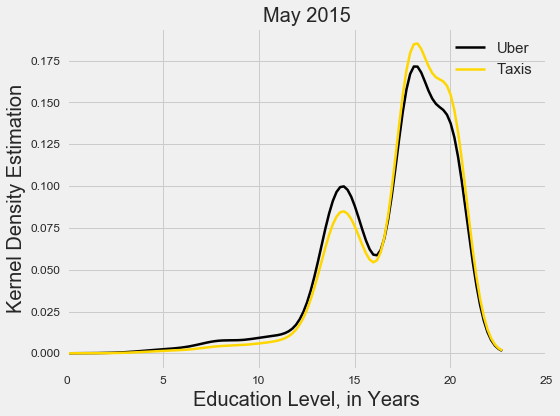

In [101]:
pl.figure(figsize=(8,6))
sns.kdeplot(ub_ker_educ['15_05']['vals'], clip=[0,23], kernel='gau', bw=0.9, color='black', label='Uber', linewidth=2.5)
sns.kdeplot(tlc_ker_educ['15_05']['vals'], clip=[0,23], kernel='gau', bw=0.9, color='gold', label='Taxis', linewidth=2.5)

pl.xlabel('Education Level, in Years', fontsize=20)
pl.ylabel('Kernel Density Estimation', fontsize=20)
pl.title('May 2015', fontsize=20)

pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
pl.xlim([0,25]);

pl.legend(fontsize=15)
pl.tight_layout(h_pad=1.0)
pl.savefig('Figures/educ_ker_1505.pdf')

### b. Income, Age & Education

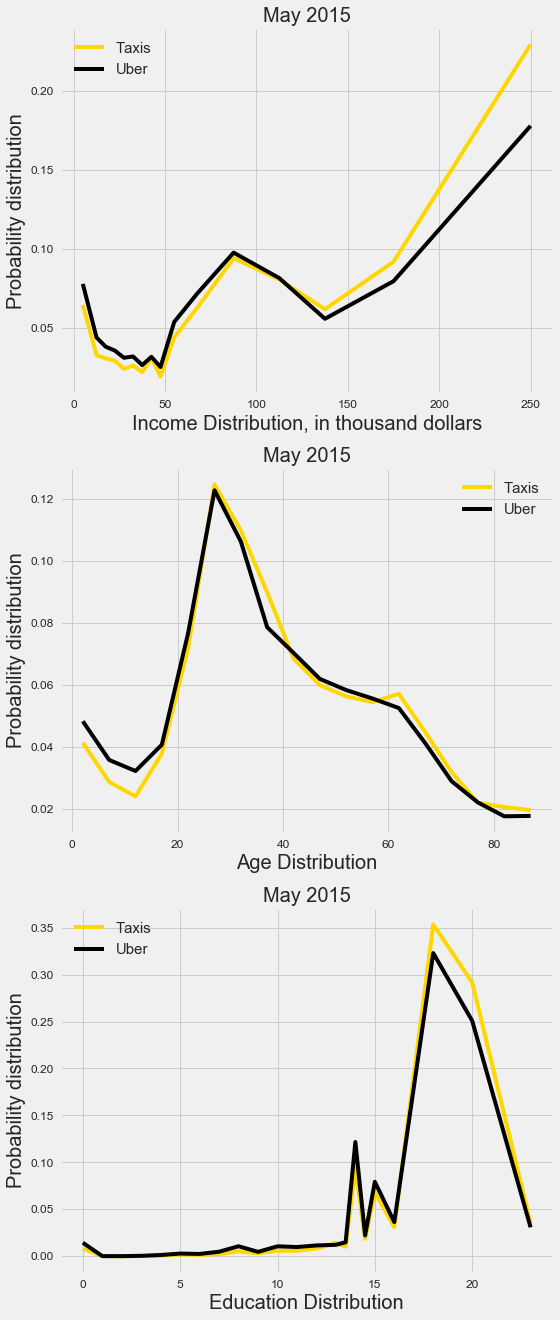

In [102]:
fig = pl.figure(figsize=(8,18))
ax1 = fig.add_subplot(311)

#Income
ax1.plot(inc_bins,tlc_inc_dens['15_05'], label='Taxis', color='Gold')
ax1.plot(inc_bins,ub_inc_dens['15_05'], label='Uber', color='Black')

pl.xlabel('Income Distribution, in thousand dollars', fontsize=20)
pl.ylabel('Probability distribution', fontsize=20)
pl.title('May 2015', fontsize=20)

pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
#pl.xlim([0,25]);
pl.legend(fontsize=15)

#Age
ax2 = fig.add_subplot(312)

ax2.plot(age_bins,tlc_age_dens['15_05'], label='Taxis', color='Gold')
ax2.plot(age_bins,ub_age_dens['15_05'], label='Uber', color='Black')

pl.xlabel('Age Distribution', fontsize=20)
pl.ylabel('Probability distribution', fontsize=20)
pl.title('May 2015', fontsize=20)

pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
#pl.xlim([0,25]);
pl.legend(fontsize=15)
pl.tight_layout(h_pad=1.0)

#Education
ax3 = fig.add_subplot(313)
ax3.plot(educ_bins,tlc_educ_dens['15_05'], label='Taxis', color='Gold')
ax3.plot(educ_bins,ub_educ_dens['15_05'], label='Uber', color='Black')

pl.xlabel('Education Distribution', fontsize=20)
pl.ylabel('Probability distribution', fontsize=20)
pl.title('May 2015', fontsize=20)

pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
#pl.xlim([0,25]);
pl.legend(fontsize=15)

pl.savefig('Figures/age_inc_educ_1505.pdf')

### c. Age only

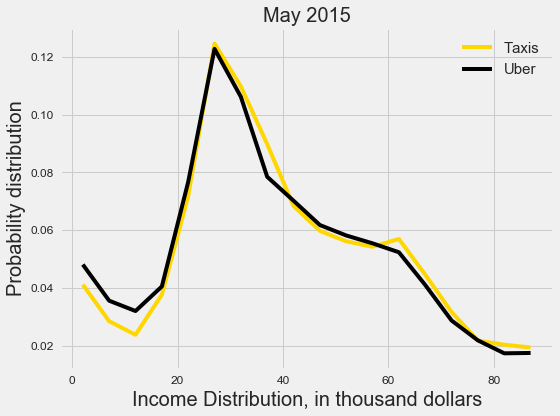

In [103]:
pl.figure(figsize=(8,6))
pl.plot(age_bins,tlc_age_dens['15_05'], label='Taxis', color='Gold')
pl.plot(age_bins,ub_age_dens['15_05'], label='Uber', color='Black')

pl.xlabel('Age Distribution, in thousand dollars', fontsize=20)
pl.ylabel('Probability distribution', fontsize=20)
pl.title('May 2015', fontsize=20)

pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
#pl.xlim([0,25]);
pl.legend(fontsize=15)

pl.tight_layout(h_pad=1.0)
pl.savefig('Figures/age_1505.pdf')

### c. Education only

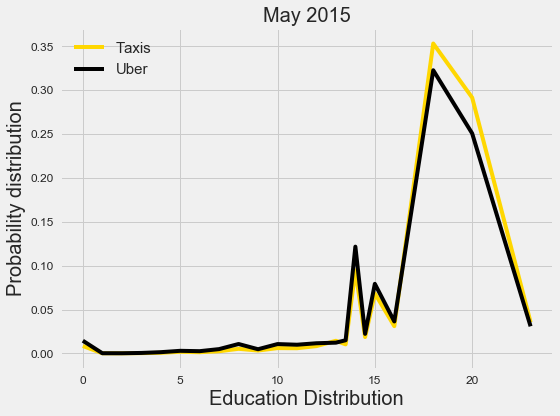

In [104]:
pl.figure(figsize=(8,6))
pl.plot(educ_bins,tlc_educ_dens['15_05'], label='Taxis', color='Gold')
pl.plot(educ_bins,ub_educ_dens['15_05'], label='Uber', color='Black')

pl.xlabel('Education Distribution', fontsize=20)
pl.ylabel('Probability distribution', fontsize=20)
pl.title('May 2015', fontsize=20)

pl.xticks(fontsize=12)
pl.yticks(fontsize=12)
#pl.xlim([0,25]);
pl.legend(fontsize=15)

pl.tight_layout(h_pad=1.0)
pl.savefig('Figures/educ_1505.pdf')

## 7. Gap between Uber and TLC
### a. RSS

In [106]:
rss = pd.DataFrame()
rss['month'] = ['14_04', '14_05', '14_07', '14_09', '15_01', '15_03', '15_05']

#Sum of squared residuals
for mth in rss['month']:
    rss.loc[rss.month == mth, 'rss_educ'] = np.sum((ub_educ_dens[mth] - tlc_educ_dens[mth])**2)*1000
    rss.loc[rss.month == mth, 'rss_inc'] = np.sum((ub_inc_dens[mth] - tlc_inc_dens[mth])**2)*1000
    rss.loc[rss.month == mth, 'rss_age'] = np.sum((ub_age_dens[mth] - tlc_age_dens[mth])**2)*1000

In [107]:
rss.index = [pd.datetime(2014,4,1), pd.datetime(2014,5,1), pd.datetime(2014,7,1), pd.datetime(2014,9,1),
            pd.datetime(2015,1,1), pd.datetime(2015,3,1), pd.datetime(2015,5,1)]

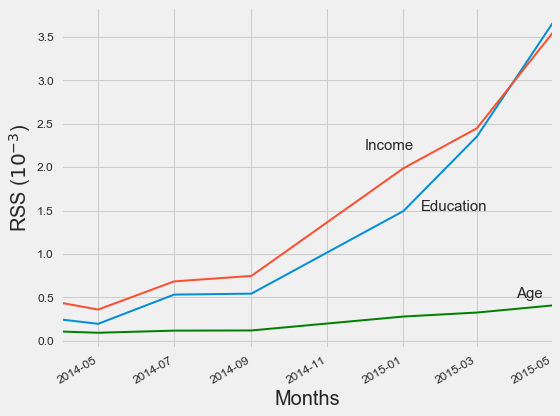

In [108]:
#Plot
fig = pl.figure(figsize=(8,6))
rss.rss_educ.plot(label='Education', linewidth=2)
rss.rss_inc.plot(label='Income', linewidth=2)
rss.rss_age.plot(label='Age', color='green', linewidth=2)

pl.xlabel('Months', fontsize=20)
pl.ylabel('RSS ($10^{-3}$)', fontsize=20)
pl.xticks(size=12)
pl.yticks(size=12);

plt.text('2014-12-1',2.2,'Income',fontsize=15)
plt.text('2015-1-15',1.5,'Education',fontsize=15)
plt.text('2015-4-1',0.5,'Age',fontsize=15)
pl.tight_layout(h_pad=1.0)
pl.savefig('Figures/rss.pdf')

### b. Percentage point difference

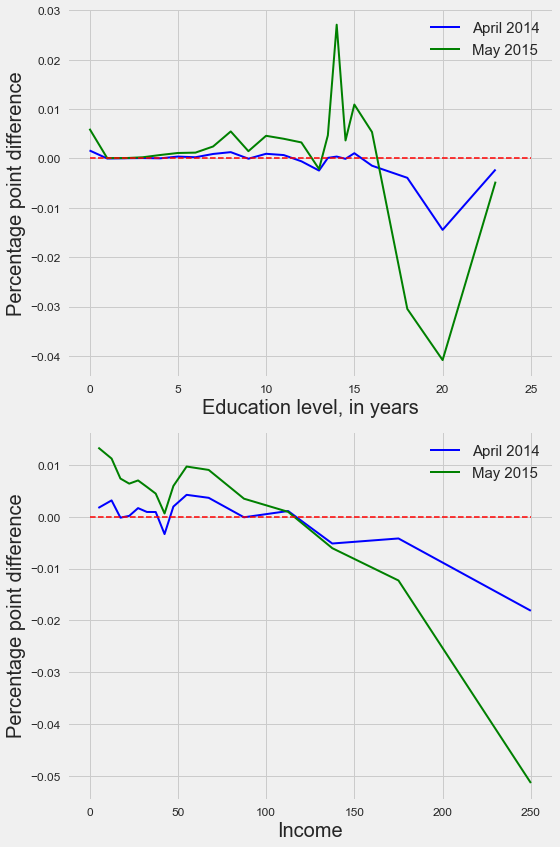

In [109]:
fig = pl.figure(figsize=(8,12))
ax1 = fig.add_subplot(211)
pl.plot(educ_bins,diff_educ['14_04'], label='April 2014', color='blue', linewidth=2)
pl.plot(educ_bins, diff_educ['15_05'], label='May 2015', color='green', linewidth=2)
pl.plot([0,25], [0,0], '--', color='red', linewidth=1.5)

pl.legend(fontsize=15)
pl.xlabel('Education level, in years', fontsize=20)
pl.ylabel('Percentage point difference', fontsize=20)

pl.xticks(fontsize=12)
pl.yticks(fontsize=12)

ax2 = fig.add_subplot(212)
pl.plot(inc_bins,diff_inc['14_04'], label='April 2014', color='blue',linewidth=2)
pl.plot(inc_bins, diff_inc['15_05'], label='May 2015', color='green', linewidth=2)
pl.plot([0,250], [0,0], '--', color='red', linewidth=1.5)

pl.legend(fontsize=15)
pl.xlabel('Income', fontsize=20)
pl.ylabel('Percentage point difference', fontsize=20)

pl.xticks(fontsize=12)
pl.yticks(fontsize=12)

pl.tight_layout(h_pad=1.0)
pl.savefig('Figures/diff.pdf')

In [111]:
ks_res = pd.DataFrame(columns=['ks', 'p', 'mth'])
ks_res['mth'] = ['14_04', '14_05', '14_07', '14_09', '15_01', '15_03', '15_05']
for mth in ks_res.mth:
    ks, p = scipy.stats.ks_2samp(ub_ker_age[mth].vals, tlc_ker_age[mth].vals)
    ks_res.loc[ks_res.mth == mth, ['ks', 'p']] = [ks, p]